Notebook containing Analysis for positron anihillation experiment

In [1]:
import compton.Dataloader as dl
from compton.Functions import *
from compton.Analysis import *
from positron.Dataloader import *
from positron.Analysis import *
import os
from sympy import symbols, Eq, latex
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pandas as pd


First step is to make a fit for energies to rescale the energy readings from the osprey. We will do this by fitting the known values of each peak vs the experimental values, to obtain a function that brings us from known value up to actual value. 

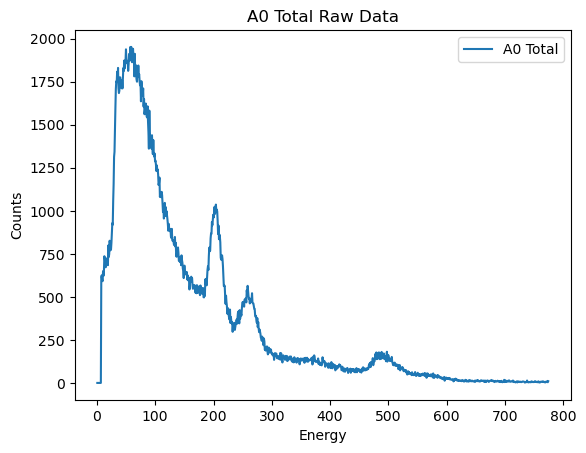

In [2]:
base_path = "../Databases/Positron/"

A0Total = load_gamma_count(base_path + "A0Total.csv")# 60 minute run?
plot_raw(A0Total, "0 Total")

Angle not int, defaulting to 0


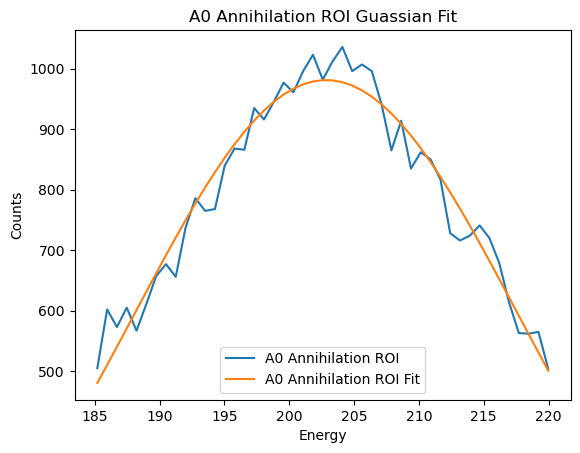

Angle not int, defaulting to 0


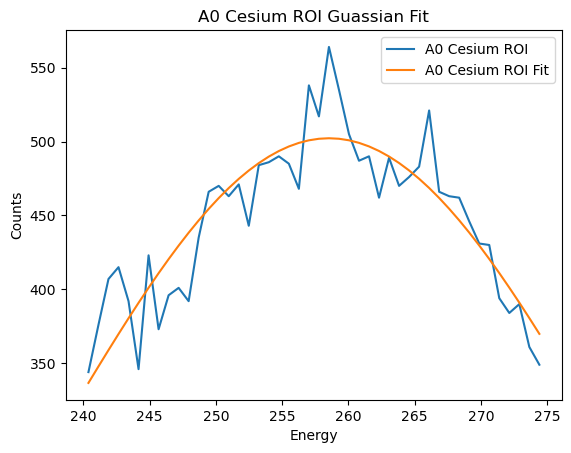

Angle not int, defaulting to 0


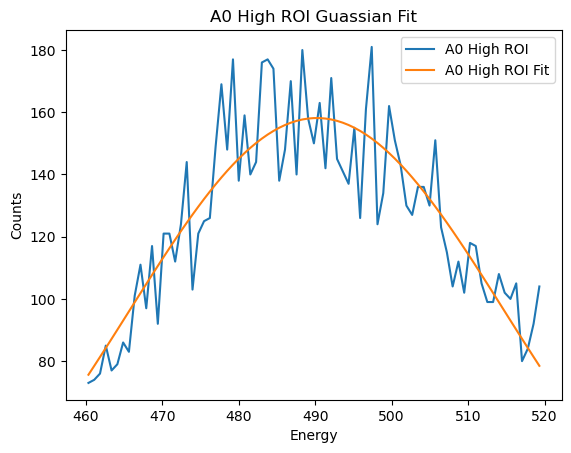

,Mean,Sigma,Unc Mean,Unc Sigma
ROI,,,,
Annihilation,202.847230,-14.770341,0.166889,0.265752
Cesium,258.528880,20.291170,0.390424,0.852191
High,490.217417,24.585945,0.519993,0.820401


In [3]:
#define 3 ROIs, that we will fit guassians to


annihilation_roi = trim_df(A0Total, 185, 220)
plot_guassian_fit(annihilation_roi, angle = "0 Annihilation ROI")

cesium_roi = trim_df(A0Total, 240, 275)
plot_guassian_fit(cesium_roi, angle = "0 Cesium ROI")

high_roi = trim_df(A0Total, 460, 520)
plot_guassian_fit(high_roi, angle = "0 High ROI", p0_overide=[175,490,20,])

ROIs = {"Annihilation": annihilation_roi, "Cesium": cesium_roi, "High": high_roi}
peaks = run_all_peak_fits(ROIs)
display(peaks)

2.651122242509284 -25.263588527897426
0.011282552897286819 3.8443393556815137


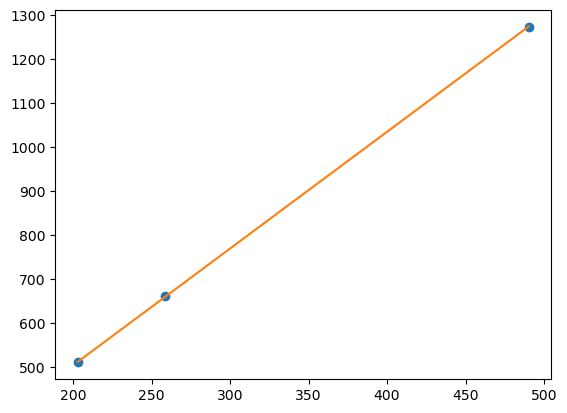

In [4]:
slope, intercept, sig_slope, sig_int = fit_plot_calibration(peaks, [511, 662, 1274])
print(slope, intercept)
print(sig_slope, sig_int)

In [5]:
dfs = load_positron_angles("../Databases/Positron/") #dfs is a dictionary, not a list
print(dfs.keys())
print(dfs[0].head())
dfs = {angle: trim_df(df, 0, 300) for angle, df in dfs.items()}



dict_keys([-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])
   Channel  Energy (keV)  Counts
0        1      0.755920       0
1        2      1.511840       0
2        3      2.267760       0
3        4      3.023679       0
4        5      3.779599       0


In [6]:
#for angle, df in dfs.items():
    #plot_raw(df, angle)

839


,Counts,Error,normalized_counts,normalized_error
Angle,,,,
-6,4,2.000000,0.004768,0.002384
-5,8,2.828427,0.009535,0.003371
-4,71,8.426150,0.084625,0.010043
-3,356,18.867962,0.424315,0.022489
-2,663,25.748786,0.790226,0.030690
-1,731,27.037012,0.871275,0.032225
0,839,28.965497,1.000000,0.034524
1,821,28.653098,0.978546,0.034151
2,558,23.622024,0.665077,0.028155


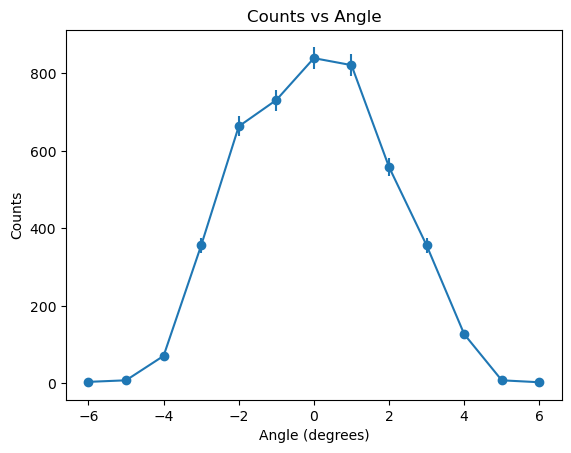

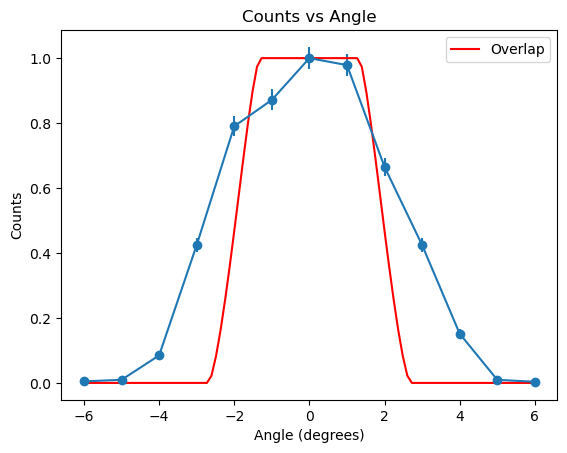

In [7]:
counts = total_counts(dfs)
display(counts)
plot_counts(counts)
plot_counts(counts, Normalized=True, overlap=True)

Part 2: time window analysis

The next step is to identify counts for specific ROIs on the 15 degree angle accidental coincidence rate

first step: obtain dataframes with counts for the 15 degree angle by ROI. should be 2 rows, one for each ROI. 
columns should be the counts per second for osprey 1, counts per second for osprey 2, and accidental coincidence counts per second

big problem: where is 1274 kev peak?!!!

I think we have to rescale the energies. not clear exactly how to do this.

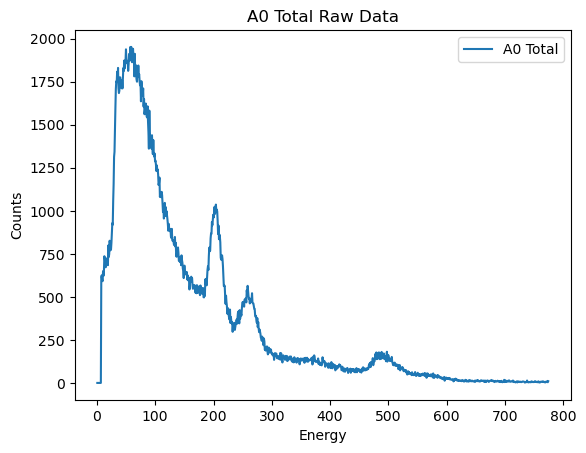

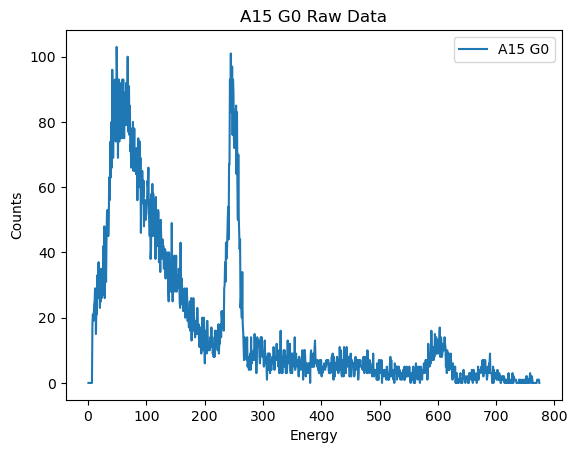

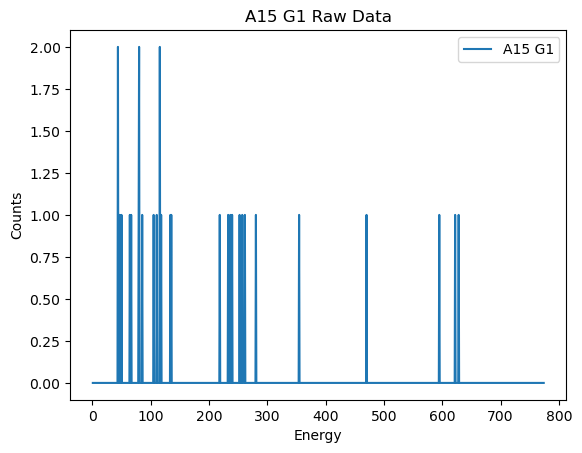

In [8]:
base_path = "../Databases/Positron/"

A0Total = load_gamma_count(base_path + "A0Total.csv", )# 60 minute run?
plot_raw(A0Total, "0 Total")
A15G0 = load_gamma_count(base_path + "A15G0.csv",) #g2 means coinicidence turned off "ungated". note: 20 minute run!
plot_raw(A15G0, "15 G0")
A15G1 = load_gamma_count(base_path + "A15G1.csv",) #G1 means coincidence turned on. "gated" note: 20 minute run!!
plot_raw(A15G1, "15 G1")

2.620791648903673 -11.92203372851878
0.055785307417716055 18.963236821917537


,Mean,Sigma,Unc Mean,Unc Sigma
ROI,,,,
Annihilation,248.564191,9.887581,0.279056,0.279649
High,601.492326,17.418740,1.027782,1.390864


2.1619132196793442 -26.37421124377178
inf inf


/home/lucas/repos/advanced_exp/positron/Analysis.py:111: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(linear, x, y,)


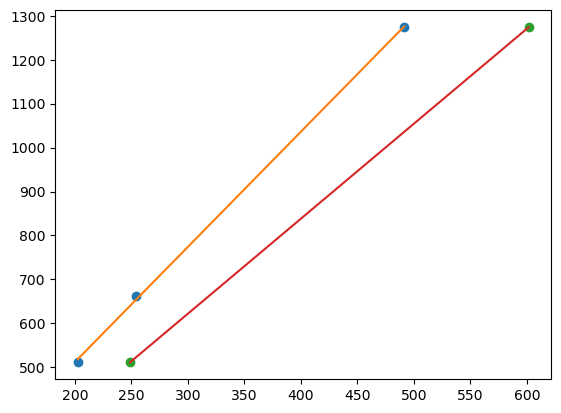

In [9]:
A0Total = recalibrate_energy(A0Total, [180, 220, 450], [220, 280, 550])
A15G0 = recalibrate_energy(A15G0, [220, 575], [280, 625])

In [10]:
slope, interept = 2.1619132196793442,  -26.37421124377178
A15G1["Energy (keV)"] = linear(A15G1["Energy (keV)"], slope, intercept)

In [11]:
"""
plot(A0Total, "0 rescaled")
plot(A15G0, "15 G0 rescaled")
plot(A15G1, "15 G1 rescaled")
"""

'\nplot(A0Total, "0 rescaled")\nplot(A15G0, "15 G0 rescaled")\nplot(A15G1, "15 G1 rescaled")\n'

/home/lucas/repos/advanced_exp/positron/Analysis.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


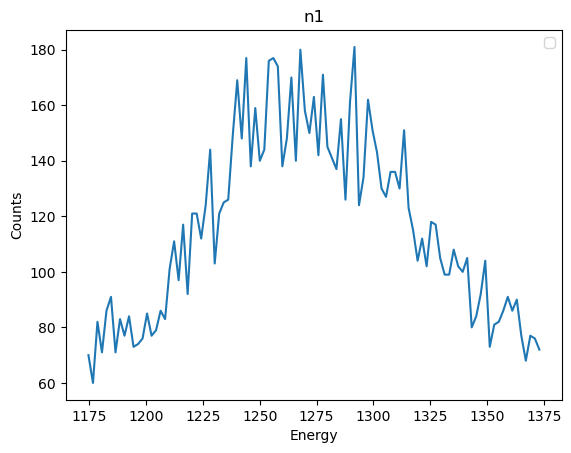

/home/lucas/repos/advanced_exp/positron/Analysis.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


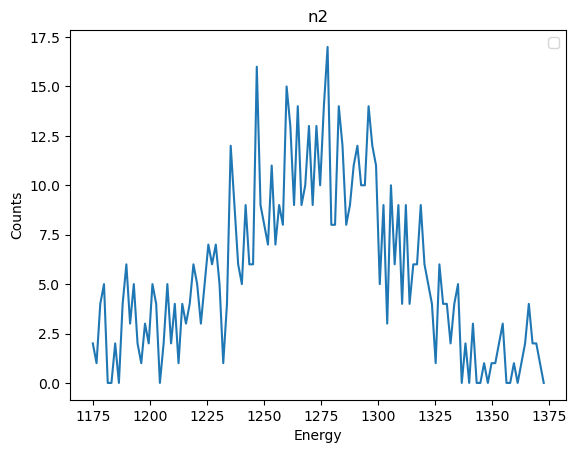

/home/lucas/repos/advanced_exp/positron/Analysis.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


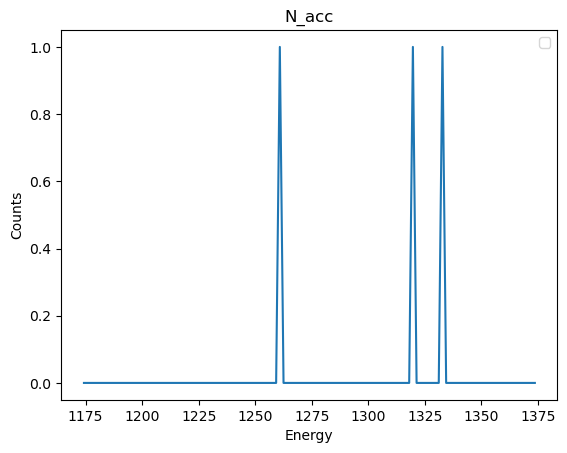

,n1,n1_error,n2,n2_error,N_acc,N_acc_error
511 KeV,33391,182.732044,2611,51.097945,6,2.449490
1274 KeV,11732,108.314357,683,26.134269,3,1.732051


,n1,n1_error,n2,n2_error,N_acc,N_acc_error,Tau (nanoseconds),Tau uncertainty
511 KeV,9.275278,0.050759,2.175833,0.042582,0.0050,0.002041,0.000248,0.000101
1274 KeV,3.258889,0.030087,0.569167,0.021779,0.0025,0.001443,0.001348,0.000780


In [12]:
observations = {"n1": A0Total, "n2": A15G0, "N_acc": A15G1}
index = ["511 KeV", "1274 KeV"]
unnormalized_rates = pd.DataFrame(index=index)
for key, df in observations.items():
    roi511 = trim_df(df, 511-40, 511+40)
    counts511 = roi511["Counts"].sum()
    
    roi1274 = trim_df(df, 1274-100, 1274+100)
    plot(roi1274, key)
    counts1274 = roi1274["Counts"].sum()
    unnormalized_rates[key] = [counts511, counts1274]
    unnormalized_rates[key+"_error"] = [np.sqrt(counts511), np.sqrt(counts1274)]
display(unnormalized_rates)

rates = time_normalize(unnormalized_rates.copy())



rates["Tau (seconds)"] = (rates["N_acc"] / (rates["n1"] * rates["n2"]))
rates["Tau uncertainty"] = window_error(rates["n1"], rates["n2"], rates["n1_error"], rates["n2_error"], rates["N_acc"], rates["N_acc_error"])
display(rates)